In [23]:
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from lightgbm.sklearn import LGBMClassifier

# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import datetime,time
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['font.family'] = ['sans-serif']

import warnings
warnings.filterwarnings("ignore")

#
#os.chdir('//Users/jinbaichuan/Desktop/毕设代码/航班延误预测/DATA/新数据/')

# 导入必备的工具包
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
import joblib

In [24]:
#!/usr/bin/env python
# coding: utf-8

# ### 使用NN进行预测
# ### Score = ？

# In[1]:
# lambda函数，可以接受多个参数，返回一个表达式的值

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 数据加载
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test1.csv')
test = test.iloc[:, 1:]
train = train.iloc[:, 1:]
train


# ##### Object类型： lan, os, osv, version, fea_hash
# ##### 有缺失值的字段： lan, osv

# In[2]:


# ['os', 'osv', 'lan', 'sid’]
features = train.columns.tolist()
#features.remove('label')
print(features)


# In[3]:


for feature in features:
    print(feature, train[feature].nunique())


# In[4]:


# 对osv进行数据清洗
def osv_trans(x):
    x = str(x).replace('Android_', '').replace('Android ', '').replace('W', '')
    if str(x).find('.')>0:
        temp_index1 = x.find('.')
        if x.find(' ')>0:
            temp_index2 = x.find(' ')
        else:
            temp_index2 = len(x)

        if x.find('-')>0:
            temp_index2 = x.find('-')
            
        result = x[0:temp_index1] + '.' + x[temp_index1+1:temp_index2].replace('.', '')
        try:
            return float(result)
        except:
            print(x+'#########')
            return 0
    try:
        return float(x)
    except:
        print(x+'#########')
        return 0
#train['osv'] => LabelEncoder ?
# 采用众数，进行缺失值的填充
train['osv'].fillna('8.1.0', inplace=True)
# 数据清洗
train['osv'] = train['osv'].apply(osv_trans)


# In[5]:


#train['os'].value_counts()
train['lan'].value_counts()
#lan_map = {'zh-CN': 1, }
train['lan'].value_counts().index
lan_map = {'zh-CN': 1, 'zh_CN':2, 'Zh-CN': 3, 'zh-cn': 4, 'zh_CN_#Hans':5, 'zh': 6, 'ZH': 7, 'cn':8, 'CN':9, 'zh-HK': 10, 'tw': 11, 'TW': 12, 'zh-TW': 13,             'zh-MO':14, 'en':15, 'en-GB': 16, 'en-US': 17, 'ko': 18, 'ja': 19, 'it': 20, 'mi':21} 
train['lan'] = train['lan'].map(lan_map)


# In[6]:


# 对于有缺失的lan 设置为22
train['lan'].fillna(22, inplace=True)



# In[7]:


remove_list = ['os', 'sid']
col = features
for i in remove_list:
    col.remove(i)
col


# In[8]:


#train['timestamp'].value_counts()
#train['timestamp'] = pd.to_datetime(train['timestamp'])
#train['timestamp']
from datetime import datetime

# lambda 是一句话函数，匿名函数
train['timestamp'] = train['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
#1559892728241.7212
#1559871800477.1477
#1625493942.538375
#import time
#time.time()


# In[9]:


def version_trans(x):
    if x=='V3':
        return 3
    if x=='v1':
        return 1
    if x=='P_Final_6':
        return 6
    if x=='V6':
        return 6
    if x=='GA3':
        return 3
    if x=='GA2':
        return 2
    if x=='V2':
        return 2
    if x=='50':
        return 5
    return int(x)
train['version'] = train['version'].apply(version_trans)
test['version'] = test['version'].apply(version_trans)
train['version'] = train['version'].astype('int')
test['version'] = test['version'].astype('int')


# In[10]:


# 特征筛选
features = train[col]
# 构造fea_hash_len特征
features['fea_hash_len'] = features['fea_hash'].map(lambda x: len(str(x)))
features['fea1_hash_len'] = features['fea1_hash'].map(lambda x: len(str(x)))
# Thinking：为什么将很大的，很长的fea_hash化为0？
# 如果fea_hash很长，都归为0，否则为自己的本身
features['fea_hash'] = features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
features['fea1_hash'] = features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
features



# In[11]:


"""
train_set = set()
for x in train['sid'].value_counts().index.tolist():
    train_set.add(x)
#train_set.add(train['sid'].value_counts().index.tolist())
train_set
test_set = set()
for x in test['sid'].value_counts().index.tolist():
    test_set.add(x)
# test_set.add(test['sid'].value_counts().index.tolist())
# test['sid'].value_counts().index.tolist()
train_set & test_set # 没有重复值
"""


# In[11]:


# 对训练集的timestamp提取时间多尺度

# 使用to_datetime进行日期类型转换
# 创建时间戳索引
temp = pd.DatetimeIndex(features['timestamp'])
features['year'] = temp.year
features['month'] = temp.month
features['day'] = temp.day
features['week_day'] = temp.weekday #星期几
features['hour'] = temp.hour
features['minute'] = temp.minute

# 求时间的diff
start_time = features['timestamp'].min()
features['time_diff'] = features['timestamp'] - start_time
features['time_diff'] = features['time_diff'].dt.days + features['time_diff'].dt.seconds/3600/24
features[['timestamp', 'year', 'month', 'day', 'week_day', 'hour', 'minute', 'time_diff']]

# 创建时间戳索引




# In[12]:


#test['version'].value_counts()
#features['version'].value_counts()
features['dev_height'].value_counts()
features['dev_width'].value_counts()
# 构造面积特征
features['dev_area'] = features['dev_height'] * features['dev_width']



# In[13]:


"""
Thinking：是否可以利用 dev_ppi 和 dev_area构造新特征
features['dev_ppi'].value_counts()
features['dev_area'].astype('float') / features['dev_ppi'].astype('float')
"""
#features['ntt'].value_counts()
features['carrier'].value_counts()
features['package'].value_counts()
# version - osv APP版本与操作系统版本差
features['osv'].value_counts()
features['version_osv'] = features['osv'] - features['version']



# In[14]:


features = features.drop(['timestamp'], axis=1)

['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi', 'dev_width', 'label', 'lan', 'media_id', 'ntt', 'os', 'osv', 'package', 'sid', 'timestamp', 'version', 'fea_hash', 'location', 'fea1_hash', 'cus_type']
android_id 362258
apptype 89
carrier 5
dev_height 798
dev_ppi 92
dev_width 346
label 2
lan 21
media_id 284
ntt 8
os 2
osv 154
package 1950
sid 500000
timestamp 500000
version 22
fea_hash 402980
location 332
fea1_hash 4959
cus_type 58
f073b_changxiang_v01_b1b8_20180915#########
%E6%B1%9F%E7%81%B5OS+5.0#########


In [25]:
data = features

In [26]:
data

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,...,fea1_hash_len,year,month,day,week_day,hour,minute,time_diff,dev_area,version_osv
0,316361,1199,46000.0,0.0,0.0,0.0,1,22.0,104,6.0,...,10,2019,6,7,4,15,32,4.647303,0.0,1.00
1,135939,893,0.0,0.0,0.0,0.0,1,22.0,19,6.0,...,10,2019,6,8,5,19,40,5.819664,0.0,4.10
2,399254,821,0.0,760.0,0.0,360.0,1,22.0,559,0.0,...,9,2019,6,6,3,23,58,3.998796,273600.0,8.10
3,68983,1004,46000.0,2214.0,0.0,1080.0,0,22.0,129,2.0,...,10,2019,6,9,6,8,59,6.374722,2391120.0,8.10
4,288999,1076,46000.0,2280.0,0.0,1080.0,1,1.0,64,2.0,...,10,2019,6,7,4,8,28,4.353009,2462400.0,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,392477,1028,46000.0,1920.0,3.0,1080.0,1,1.0,144,6.0,...,9,2019,6,6,3,23,14,3.968252,2073600.0,0.12
499996,346134,1001,0.0,1424.0,0.0,720.0,0,22.0,29,2.0,...,10,2019,6,6,3,17,40,3.736713,1025280.0,5.10
499997,499635,761,46000.0,1280.0,0.0,720.0,0,22.0,54,6.0,...,10,2019,6,5,2,3,14,2.135370,921600.0,6.01
499998,239786,917,46001.0,960.0,0.0,540.0,0,2.0,109,2.0,...,10,2019,6,7,4,0,59,4.041273,518400.0,5.11


In [27]:
data_soure = data

## SVD

#SVD 如果不要int类型，可以drop掉int的类型，论文就是直接利用string类型的构建SVD分解的原始矩阵A。pd.drop的。

In [28]:
## test 测试K的值能不能改变。
from sklearn.utils.extmath import randomized_svd
def svd(inter_matrix, dim):
    u, sigma, vt = randomized_svd(inter_matrix, n_components=dim, n_iter=20, random_state=2021)
    return u, sigma,vt

u_svd_vector, sigma,a_svd_vector = svd(data.to_numpy(),12)

##维度只能是小于特征值的。

In [29]:
u_svd_vector.shape, sigma.shape,a_svd_vector.shape

((500000, 12), (12,), (12, 28))

In [30]:
from sklearn.utils.extmath import randomized_svd
def svd(inter_matrix, dim):
    u, sigma, vt = randomized_svd(inter_matrix, n_components=dim, n_iter=20, random_state=2021)
    return u, sigma,vt

u_svd_vector, sigma,a_svd_vector = svd(data.to_numpy(),16)

svd_data = pd.DataFrame(u_svd_vector).reset_index()

svd_data.columns = ['id'] + ['SVD_' + str(i) for i in range(16)]

data_1 = data

n = len(data_1)
nlist = range(0,n)
data_1['id'] = nlist

X_new_train = pd.merge(data_1,svd_data,on='id',how='left')

X_new_train.drop(columns='id', inplace=True)

In [31]:
data = X_new_train

In [32]:
data

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,...,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,SVD_11,SVD_12,SVD_13,SVD_14,SVD_15
0,316361,1199,46000.0,0.0,0.0,0.0,1,22.0,104,6.0,...,-0.000042,0.001452,0.000823,0.001706,0.000025,-0.000359,0.001539,-0.001056,-0.001487,-0.000217
1,135939,893,0.0,0.0,0.0,0.0,1,22.0,19,6.0,...,0.000005,0.000747,-0.000867,0.000776,-0.000886,-0.000552,0.000020,0.001152,-0.001511,-0.000852
2,399254,821,0.0,760.0,0.0,360.0,1,22.0,559,0.0,...,0.000066,-0.002148,0.000532,-0.001563,0.002510,0.002007,0.001180,0.000605,-0.001568,-0.002351
3,68983,1004,46000.0,2214.0,0.0,1080.0,0,22.0,129,2.0,...,0.000013,-0.000270,0.000079,0.000768,-0.000298,0.000670,0.000464,-0.000460,-0.001535,-0.002414
4,288999,1076,46000.0,2280.0,0.0,1080.0,1,1.0,64,2.0,...,-0.000025,-0.000784,0.001160,0.000990,-0.000888,0.000301,0.000160,-0.001241,-0.001459,0.000120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,392477,1028,46000.0,1920.0,3.0,1080.0,1,1.0,144,6.0,...,-0.000005,-0.000636,0.002588,0.000042,-0.000027,0.000469,-0.000018,-0.000625,-0.000219,0.001257
499996,346134,1001,0.0,1424.0,0.0,720.0,0,22.0,29,2.0,...,-0.000008,-0.002899,0.001118,-0.001689,-0.001318,-0.000122,-0.001277,-0.001882,-0.001267,-0.000860
499997,499635,761,46000.0,1280.0,0.0,720.0,0,22.0,54,6.0,...,-0.000019,-0.000775,-0.000748,-0.001179,-0.001002,0.000389,-0.000908,0.001931,-0.001297,0.001264
499998,239786,917,46001.0,960.0,0.0,540.0,0,2.0,109,2.0,...,0.000002,-0.000590,-0.000634,-0.001071,-0.000306,0.000390,-0.000072,0.000564,0.002006,-0.002419


In [33]:
data['label'].value_counts()

0    257760
1    242240
Name: label, dtype: int64

In [34]:
%%time
target = 'label'
y = data[target]
X = data.drop([target], 1)#
# 数据均衡--过采样
#数据平衡

#数据集分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#42，
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

CPU times: user 102 ms, sys: 62.2 ms, total: 164 ms
Wall time: 276 ms


((400000, 43), (100000, 43), (400000,), (100000,))

In [35]:
import os
import numpy as np
import pandas as pd
import datetime,time
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['font.family'] = ['sans-serif']

import warnings
warnings.filterwarnings("ignore")



# 导入必备的工具包
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
import joblib

## LightGBM

In [37]:
%%time
# 开始训练
print("Start training.....")
gbm = lgb.LGBMClassifier(boosting_type='gbdt', 
                              objective='binary',
#                               feature_fraction=0.9,
#                               bagging_fraction=0.6,
                              num_leaves=31,
                              max_depth=-1,
                              learning_rate=0.05,
                              n_estimators=4800,#2000
                              min_child_samples=36,
                              n_jobs=-1)
gbm.fit(X_train,y_train,eval_set=[(X_test, y_test)], eval_metric="l1", early_stopping_rounds=100)
print("end")

Start training.....
[1]	valid_0's l1: 0.486325	valid_0's binary_logloss: 0.66692
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 0.473731	valid_0's binary_logloss: 0.643431
[3]	valid_0's l1: 0.4618	valid_0's binary_logloss: 0.622162
[4]	valid_0's l1: 0.450533	valid_0's binary_logloss: 0.602761
[5]	valid_0's l1: 0.439584	valid_0's binary_logloss: 0.584663
[6]	valid_0's l1: 0.429463	valid_0's binary_logloss: 0.568529
[7]	valid_0's l1: 0.419467	valid_0's binary_logloss: 0.55303
[8]	valid_0's l1: 0.41024	valid_0's binary_logloss: 0.539228
[9]	valid_0's l1: 0.401281	valid_0's binary_logloss: 0.526229
[10]	valid_0's l1: 0.39273	valid_0's binary_logloss: 0.514174
[11]	valid_0's l1: 0.384684	valid_0's binary_logloss: 0.503216
[12]	valid_0's l1: 0.377111	valid_0's binary_logloss: 0.493092
[13]	valid_0's l1: 0.369749	valid_0's binary_logloss: 0.483536
[14]	valid_0's l1: 0.362717	valid_0's binary_logloss: 0.47467
[15]	valid_0's l1: 0.356146	valid_0's binary_logloss

In [38]:
import lightgbm as lgb
gbm_pred = gbm.predict(X_test)
gbm_preprob = gbm.predict_proba(X_test)[:,1]
print("Accuracy : %.4g" % accuracy_score(y_test,gbm_pred))
print("AUC : %.4g" % roc_auc_score(y_test,gbm_preprob))
joblib.dump(gbm,'./lightgbm_with_svd.pkl')
fpr_lightgbm_lm, tpr_lightgbm_lm, _ = roc_curve(y_test, gbm_preprob)

Accuracy : 0.8897
AUC : 0.9428


## LR

In [39]:
%%time
####加一个逻辑回归，用于画图
log = LogisticRegression(solver='lbfgs',max_iter=1000) 
log.fit(X_train,y_train)  # fitting the data
y_pred_test1 = log.predict_proba(X_test)[:,1]
y_pred1 = log.predict(X_test)
print("Accuracy : %.4g" % accuracy_score(y_test,y_pred1))
print("AUC : %.4g" % roc_auc_score(y_test,y_pred_test1))
joblib.dump(log,'./lr_with_svd.pkl')
fpr_logistic_lm, tpr_logistic_lm, _ = roc_curve(y_test, y_pred_test1)

Accuracy : 0.5517
AUC : 0.6099
CPU times: user 3.95 s, sys: 783 ms, total: 4.74 s
Wall time: 1.39 s


## LightGBM+LR

In [40]:
# 得到OneHot编码
from sklearn.preprocessing import OneHotEncoder
lgb_enc = OneHotEncoder(categories='auto')
lgb_enc.fit(gbm.predict(X_train,pred_leaf=True))

OneHotEncoder()

In [41]:
%%time
lgb_lm1 = LogisticRegression(solver='lbfgs', max_iter=1000)
lgb_lm1.fit(lgb_enc.transform(gbm.predict(X_train,pred_leaf=True)), y_train)
# 使用LR进行预测
y_pred_lgb_lm = lgb_lm1.predict_proba(lgb_enc.transform(gbm.predict(X_test,pred_leaf=True)))[:, 1]
y_pred1 = lgb_lm1.predict(lgb_enc.transform(gbm.predict(X_test,pred_leaf=True)))
print("Accuracy : %.4g" % accuracy_score(y_test,y_pred1))
print("AUC : %.4g" % roc_auc_score(y_test,y_pred_lgb_lm))
##### 画图使用
joblib.dump(lgb_lm1,'./lightgbm_lr_with_svd.pkl')
fpr_lightgbm_lr_lm, tpr_lightgbm_lr_lm, _ = roc_curve(y_test, y_pred_lgb_lm)

Accuracy : 0.8722
AUC : 0.9251
CPU times: user 1h 5min 3s, sys: 2h 30min 44s, total: 3h 35min 48s
Wall time: 4h 48min 7s


## XGBoost

In [42]:
%%time
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=12,
                    learning_rate=0.1, 
                    n_estimators=145, 
                    objective="binary:logistic", 
                    n_jobs=-1, 
                    nthread=4, 
                    min_child_weight=1,
                    subsample=1,
                    colsample_bytree=0.6,
                    seed=42)
xgb.fit(X_train, y_train, eval_metric="logloss", eval_set=[(X_test, y_test)], early_stopping_rounds=100)

[0]	validation_0-logloss:0.63412
[1]	validation_0-logloss:0.58780
[2]	validation_0-logloss:0.54672
[3]	validation_0-logloss:0.51475
[4]	validation_0-logloss:0.48524
[5]	validation_0-logloss:0.45930
[6]	validation_0-logloss:0.43730
[7]	validation_0-logloss:0.41863
[8]	validation_0-logloss:0.40231
[9]	validation_0-logloss:0.38908
[10]	validation_0-logloss:0.37640
[11]	validation_0-logloss:0.36532
[12]	validation_0-logloss:0.35613
[13]	validation_0-logloss:0.34826
[14]	validation_0-logloss:0.34149
[15]	validation_0-logloss:0.33573
[16]	validation_0-logloss:0.33016
[17]	validation_0-logloss:0.32562
[18]	validation_0-logloss:0.32180
[19]	validation_0-logloss:0.31858
[20]	validation_0-logloss:0.31513
[21]	validation_0-logloss:0.31243
[22]	validation_0-logloss:0.30998
[23]	validation_0-logloss:0.30742
[24]	validation_0-logloss:0.30574
[25]	validation_0-logloss:0.30390
[26]	validation_0-logloss:0.30269
[27]	validation_0-logloss:0.30119
[28]	validation_0-logloss:0.30009
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=145, n_jobs=-1, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [43]:
xgb_pred = xgb.predict(X_test)
xgb_preprob = xgb.predict_proba(X_test)[:,1]
print("Accuracy : %.4g" % accuracy_score(y_test,xgb_pred))
print("AUC : %.4g" % roc_auc_score(y_test,xgb_preprob))
## 绘图使用
joblib.dump(xgb,'./xgboost.pkl')
fpr_xgb_lm, tpr_xgb_lm, _ = roc_curve(y_test, xgb_preprob)

Accuracy : 0.8906
AUC : 0.9433


## XGBoost+LR

In [44]:
%%time
# 得到OneHot编码
grd_enc = OneHotEncoder(categories='auto')
grd_enc.fit(xgb.apply(X_train))
# 使用OneHot编码作为特征，训练LR
grd_lm_xgb = LogisticRegression(solver='lbfgs', max_iter=1000)
grd_lm_xgb.fit(grd_enc.transform(xgb.apply(X_train)), y_train)

CPU times: user 4min 9s, sys: 1min 13s, total: 5min 23s
Wall time: 1min 50s


LogisticRegression(max_iter=1000)

In [45]:
# 使用LR进行预测
y_pred_xgb_lm = grd_lm_xgb.predict_proba(grd_enc.transform(xgb.apply(X_test)))[:, 1]
y_pred_xgb = grd_lm_xgb.predict(grd_enc.transform(xgb.apply(X_test)))
print("Accuracy : %.4g" % accuracy_score(y_test,y_pred_xgb))
print("AUC : %.4g" % roc_auc_score(y_test,y_pred_xgb_lm))
joblib.dump(grd_lm_xgb,'./xgboost_lr_with_svd.pkl')
fpr_xgb_lr_lm, tpr_xgb_lr_lm, _ = roc_curve(y_test, y_pred_xgb_lm)

Accuracy : 0.8741
AUC : 0.927


## GBDT

In [46]:
%%time
gbdt = GradientBoostingClassifier(n_estimators=100,max_depth=10)#
gbdt.fit(X_train,y_train)
gbdt_pred = gbdt.predict(X_test)
gbdt_preprob = gbdt.predict_proba(X_test)[:,1]
print("Accuracy : %.4g" % accuracy_score(y_test,gbdt_pred))
print("AUC : %.4g" % roc_auc_score(y_test,gbdt_preprob))
joblib.dump(gbdt,'./gbdt_with_svd.pkl')
fpr_gbdt_lm, tpr_gbdt_lm, _ = roc_curve(y_test, gbdt_preprob)

Accuracy : 0.8892
AUC : 0.943
CPU times: user 13min 58s, sys: 6.59 s, total: 14min 5s
Wall time: 14min 5s


## GBDT+LR

In [47]:
%%time
# 得到OneHot编码
grd_enc = OneHotEncoder(categories='auto')
grd_enc.fit(gbdt.apply(X_train)[:, :, 0])
# 使用OneHot编码作为特征，训练LR
grd_lm_gbdt = LogisticRegression(solver='lbfgs', max_iter=1000)
grd_lm_gbdt.fit(grd_enc.transform(gbdt.apply(X_train)[:, :, 0]), y_train)

CPU times: user 3min 28s, sys: 1min 1s, total: 4min 29s
Wall time: 1min 37s


LogisticRegression(max_iter=1000)

In [51]:
# 使用LR进行预测
y_pred_gbdt_lm = grd_lm_gbdt.predict_proba(grd_enc.transform(gbdt.apply(X_test)[:, :, 0]))[:, 1]
y_pred_gbdt_lr = grd_lm_gbdt.predict(grd_enc.transform(gbdt.apply(X_test)[:, :, 0]))
print("Accuracy : %.4g" % accuracy_score(y_test,y_pred_gbdt_lr))
print("AUC : %.4g" % roc_auc_score(y_test,y_pred_gbdt_lm))
## 画图用
joblib.dump(grd_lm_gbdt,'./gbdt_lr_with_svd.pkl')
fpr_gbdt_lr_lm, tpr_gbdt_lr_lm, _ = roc_curve(y_test, y_pred_gbdt_lm)

Accuracy : 0.8807
AUC : 0.9311


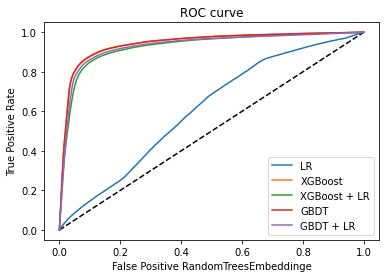

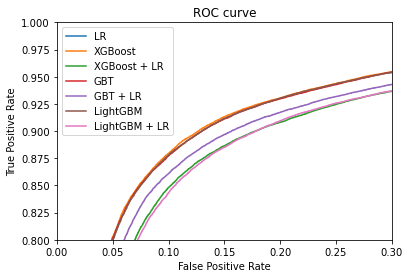

In [54]:
import os
import numpy as np
import pandas as pd
import datetime,time
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams['font.family'] = ['sans-serif']

import warnings
warnings.filterwarnings("ignore")

#
#os.chdir('//Users/jinbaichuan/Desktop/毕设代码/航班延误预测/DATA/新数据/')

# 导入必备的工具包
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
import joblib
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_logistic_lm, tpr_logistic_lm, label='LR')  

plt.plot(fpr_xgb_lm, tpr_xgb_lm, label='XGBoost')  #
plt.plot(fpr_xgb_lr_lm, tpr_xgb_lr_lm, label='XGBoost + LR')  #

plt.plot(fpr_gbdt_lm, tpr_gbdt_lm, label='GBDT') #
plt.plot(fpr_gbdt_lr_lm, tpr_gbdt_lr_lm, label='GBDT + LR') #

# plt.plot(fpr_lightgbm_lm, tpr_lightgbm_lm, label='LightGBM') #
# plt.plot(fpr_lightgbm_lr_lm, tpr_lightgbm_lr_lm, label='LightGBM + LR') 

plt.xlabel('False Positive RandomTreesEmbeddinge')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.savefig('with_svd_roc.jpg', dpi=300)
plt.show()


# 将左上角放大显示
plt.figure(2)
plt.xlim(0, 0.3)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_logistic_lm, tpr_logistic_lm, label='LR')  

plt.plot(fpr_xgb_lm, tpr_xgb_lm, label='XGBoost')  
plt.plot(fpr_xgb_lr_lm, tpr_xgb_lr_lm, label='XGBoost + LR')  

plt.plot(fpr_gbdt_lm, tpr_gbdt_lm, label='GBT')  
plt.plot(fpr_gbdt_lr_lm, tpr_gbdt_lr_lm, label='GBT + LR')  

plt.plot(fpr_lightgbm_lm, tpr_lightgbm_lm, label='LightGBM')  
plt.plot(fpr_lightgbm_lr_lm, tpr_lightgbm_lr_lm, label='LightGBM + LR') 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.savefig('with_svd_roc_part.jpg', dpi=300)
plt.show()



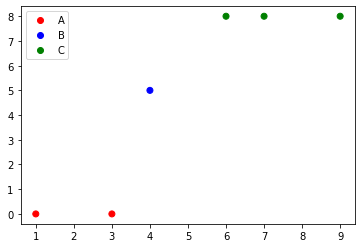

In [53]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
 
x = [1, 3, 4, 6, 7, 9]
y = [0, 0, 5, 8, 8, 8]
classes = ['A', 'B', 'C']
values = [0, 0, 1, 2, 2, 2]
colors = ListedColormap(['r','b','g'])
scatter = plt.scatter(x, y, c=values, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)